# Baseline Model
As a simple model for this binary prediction, we choose logistic regression. This is both a conceptually simple and easy to interpret model, and can be extended to include more classes if necessary.

In this logistic regression model, we have to preprocess the data. For categorical variables this means creating dummy variables and for continuous variables, it means centering and scaling the data by the mean and standard deviation respectively. Many solvers that are optimized for large datasets perfrom better when the variables have similar ranges.

Then we get rid of variables involving arbitrary dates, such as date that the survey was administered, or the student's birth date. These will be difficult to handle in a logistic regression context. Variables such as 'parent's birth year' should work fine, as it is a single number.

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
#import student data from wrangling stage
filepath = '/Users/chrismalec/DS_Portfolio/CapstoneProjectOne/'
df_BY = pd.read_pickle(filepath + 'df_BY.pkl')
labels = pd.read_pickle(filepath + 'labels.pkl')
df_weights = pd.read_pickle(filepath + 'df_weights.pkl')

#Read in the vector of labels
import pickle
pickle_in = open(filepath+'number_labels.pkl',"rb")
number_labels = pickle.load(pickle_in)

In [4]:
#Create two groups of variables: continuous and discrete
cont_var = []
disc_var = []

for key in df_BY.columns:
    #Continuous variables do not have to explain what each number means
    if list(number_labels[key].keys()) == ['desc']:
        cont_var.append(key)
    #This catches the few variables that have no description
    elif 'desc' not in list(number_labels[key].keys()):
        continue
    #Everything else is a discrete variable
    else:
        disc_var.append(key)
        
print('There are %f continuous variables and %f discrete variables' 
      %(len(cont_var),len(disc_var)))

There are 100.000000 continuous variables and 937.000000 discrete variables


In [5]:
#Dealing with dates in this context is difficult, and considering there are only a few variables, I just get rid of them
cont_var = [x for x in cont_var if not re.search("YYYYMM",number_labels[x]['desc'])]
Student_ID = cont_var.pop(0)
print('Now there are %f continuous variables' %(len(cont_var)))

Now there are 91.000000 continuous variables


## Handling missing data

At this point, there is not much missing data, but there are several different codes that refer to missing data. We will refer to most of these codes as nan, however non-response data is left as '-8' for discrete variables, as this represents a distinct category from the other types of missing data. All missing codes are converted to nan for continuous variables, as the values of the missing data can throw off the mean and standard deviations by quite a bit. For example, a score that ranges from 0 to 1 could have its mean significantly altered by only a few -8's.

In [6]:
#-4 means a follow through missing, 
#-5 is suppressed in public use data and was already cleaned,
#-6 is an abbreviated interview, 
#-7 is a legitimate skip, 
#-8 is a non-response,
#-9 is missing
for column in disc_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    df_BY.loc[df_BY[column] == -8,column] = np.nan
    #-8 is not labeled nan because it is an omission on the part of the subject, not the researcher
    df_BY.loc[df_BY[column] == -9,column] = np.nan
for column in cont_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    #Keeping -8 as is in continuous data would mess up the continuous variable means
    df_BY.loc[df_BY[column] == -8,column] = np.nan
    df_BY.loc[df_BY[column] == -9,column] = np.nan
    


## Preprocessing
The continuous variables are scaled and centered, since some solvers operate better when all variables have a similar average magnitude. We also make sure there are no rows or columns that contain only 'na' values. The few na values present in the data are imputed using the mode of each column, as this will work for both the categorical variables.

Finally, the independent variables are placed in an array, and the target variable is placed in a second array. We print out the number of dropouts and non-dropouts, and can see that we are dealing with unbalanced classes with the non-dropout category having nearly ten times more observations than the dropout category.

In [21]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_BY[cont_var]),columns = cont_var)
df[disc_var] = df_BY[disc_var]

df = pd.get_dummies(df,prefix=disc_var,columns=disc_var,dummy_na=True)
df['Dropout'] = labels
df = df[df.Dropout != -8]
df = df[df.Dropout != -9]
df = df.dropna(axis = 0, how = 'all')
df = df.dropna(axis = 1, how = 'all')

num_obs = df.shape[0]
mode_imputer = SimpleImputer(strategy = "most_frequent")
y = np.array(df.Dropout)
df = df.drop('Dropout', axis = 1)
X = mode_imputer.fit_transform(df)

In [49]:
print("There are",np.sum(y == 1),"dropouts, and",np.sum(y == 0),"non-droupouts in the dataset" )

There are 2576 dropouts, and 20927 non-droupouts in the dataset


## Training and Testing the Model

In order to make sure that our model can predict unseen data, we split it into testing and training sets. The training set will be used to cross_validate the hyperparameters for the model, while the testing set will be used to validate the model.

We first make a model with default parameters. Since the classes are unbalanced, the algorithm could conceivably get very high accuracy by under-estimating the number of dropouts. For example, about 14% of the observations contain a student who dropped out of high school, a model could therefore be 86% accurate by assuming everyone graduates. Therefore, we use a 'classification report' to assess the model's efficacy.

The 'precision', or the proportion of true positive to all positively identified variables, measures how many students the model correctly identified as dropped out compared to how many the model claims to have dropped out. The 'recall', or the propoportion of true positives to all observations that were actually true, measures how many students the model correctly identified as dropping out compared to the number that actually dropped out.

In [23]:
#Split into test/train
df.reset_index(inplace = True)
n_obs = df.shape[0]
n_train = round(0.67*n_obs)
shuffle_index = np.random.choice(df.index, size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

In [24]:
#Create X and y arrays
X_train = X[train_index,:]
X_test = X[test_index,:]

y_train = y[train_index]
y_test = y[test_index]

#train_weight = np.array(df_weights.loc[train_index,'W1STUDENT'])
train_weight = np.array(df_weights.loc[train_index,'W1STUDENT'])

In [25]:
#Train model with default parameters
model = LogisticRegression(solver = 'liblinear',multi_class = 'ovr')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))

              precision    recall  f1-score   support

 Non-Dropout       0.93      0.85      0.89      6941
     Dropout       0.25      0.43      0.32       815

   micro avg       0.80      0.80      0.80      7756
   macro avg       0.59      0.64      0.60      7756
weighted avg       0.86      0.80      0.83      7756



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Tuning and Optimizing the Model

In logistic regression, the regularization constant 'C' is the only major parameter. We are also free to choose either an 'L1' or an 'L2' penalty referring to what power in the variables we use to calculate the regularization parameter. We will keep track of the testing and training error as well as the precision and recall. Again, with unbalanced classes, the testing and training error may not give a clear indication of which parameters are optimal, so we will use precision and recall to make a final decision.

In [26]:
#Create models
Cs = np.geomspace(1e-7,1e1,17)
models_L1 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l1') for C in Cs]
models_L2 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l2') for C in Cs]
models = models_L1 + models_L2

In [27]:
#Optimization
from sklearn.model_selection import KFold

df_cv = pd.DataFrame(data = {'C':[],
                            'penalty':[],
                            'train_error':[],
                            'test_error':[],
                            'precision':[],
                            'recall':[]})
for model in models:
    kf = KFold(n_splits=3,shuffle = True, random_state = 673)
    train_scores = []
    test_scores = []
    precisions = []
    recalls = []
    for traincv_index, testcv_index in kf.split(X_train,y_train):
        model.fit(X_train[traincv_index,:],
                  y_train[traincv_index],
                  sample_weight = train_weight[traincv_index])
        
        y_testcv = y_train[testcv_index]
        y_predictcv = model.predict(X_train[testcv_index,:])
        
        report = classification_report(y_testcv,y_predictcv,output_dict = True)
        
        precisions.append(report['1']['precision'])
        recalls.append(report['1']['recall'])
        train_scores.append(model.score(X_train[traincv_index,:],y_train[traincv_index]))
        test_scores.append(model.score(X_train[testcv_index,:],y_train[testcv_index]))
    
    row = [model.get_params()['C'],
          model.get_params()['penalty'],
          1-np.median(train_scores),
          1-np.median(test_scores),
          np.median(precisions),
          np.median(recalls)]
    df_cv = df_cv.append(pd.DataFrame([row],columns = df_cv.columns),ignore_index = True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

KeyboardInterrupt: 

Optimal is always a trade-off between several competing needs. We would like a model that is as accurate as possible while performing well on unseen data. When deciding on how to proceed with a tradeoff, it is important to identify the consequences of certain types of mistakes. Guidance from a school or school district would be important when deciding the sensible goals for precision and recall numbers.

In our specific case, identifying a student at risk for dropping out when that student is actually not at risk is acceptable as long as this does not happen so often as to undermine interventions. However, missing an identification of a student who is actually at risk for dropping out is undesirable, as an intervention may have helped this student. Therefore, we would prefer better recall over better precision.

We see from the graphs below for the L2 penalty that the test error rises rapidly for C > 1e-5. This is also the point at which precision and recall are about the same. However, most values of C have much lower precision than recall.  For the L1 penalty, the error rises for C > 1e-3, but not as rapidly as for the L2. Recall is lower for the L1 penalty, but it is still on par with the L2 penalty and does have as big a loss in precision.

Taking all this into account, we select C = 1e-3 with an L1 penalty to maintain low test error and maximize recall.

In [28]:
#Create dataframes conducive to plots
df_plot1 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['train_error','test_error'],value_name = 'error',var_name = 'error_type')
df_plot1['logC'] = np.log10(df_plot1.C)
df_plot2 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['precision','recall'],value_name = 'classification',var_name = 'class_type')
df_plot2['logC'] = np.log10(df_plot2.C)

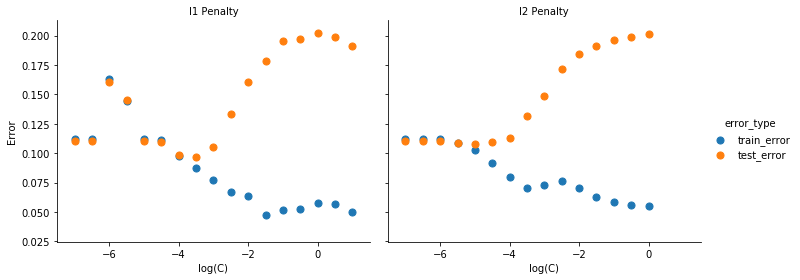

In [29]:
import seaborn as sns
g = sns.FacetGrid(df_plot1,
                  col = 'penalty',
                  hue = 'error_type',
                  height = 4,
                  aspect = 1.25
                 )
g = g.map(plt.scatter,
          'logC',
          'error',
          s = 50
         )
g = g.set_axis_labels('log(C)','Error')
g = g.set_titles('{col_name} Penalty')
g = g.add_legend()
plt.show()

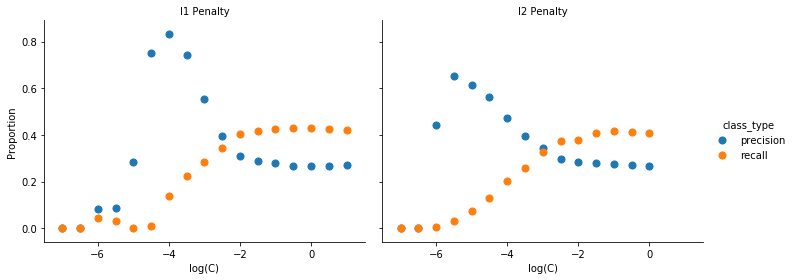

In [30]:
g = sns.FacetGrid(df_plot2,
                  col = 'penalty',
                  hue = 'class_type',
                  height = 4,
                  aspect = 1.25
                 )
g = g.map(plt.scatter,
          'logC',
          'classification',
          s = 50
         )
g = g.set_axis_labels('log(C)','Proportion')
g = g.set_titles('{col_name} Penalty')
g = g.add_legend()
plt.show()

In [31]:
#Train model with optimal parameters and apply to test set
model = LogisticRegression(solver = 'liblinear', C = 1e-2, penalty = 'l1')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict,target_names = ['Non-Dropout','Dropout']))

              precision    recall  f1-score   support

 Non-Dropout       0.93      0.90      0.91      6941
     Dropout       0.32      0.40      0.35       815

   micro avg       0.85      0.85      0.85      7756
   macro avg       0.62      0.65      0.63      7756
weighted avg       0.86      0.85      0.86      7756



In [32]:
#Save X, y, feature names, and training weights for use in model extensions
np.save('X', X)
np.save('y', y)
weight = np.array(df_weights.loc[:,'W1STUDENT'])
np.save('weight', weight)
f = open(filepath+'feature_names.pkl','wb')
pickle.dump(df.columns,f)
f.close()

## Interpretation of Model Coefficients

We would now like to actually see what the model says about our problem. The interpretation of the coefficients in logistic regression is straightforward, particularly for a binary outcome. Each coefficient is related to the odds of changing from the non-dropout class to the drop out class for a unit change in the variable. So for a variable $\beta$:

$e^{\beta} = \frac{Prob(dropout)}{1-Prob(dropout)}$

We therefore look at the top five negative coefficients, meaning the items associated with lowering the odds of dropping out, and the top five positive coefficients, meaning the items associated with raising the odds of dropping out. We also look at three neutral coefficients, which don't really effect outcomes one way or the other.

In [50]:
#Find top five positive, top five negative, 
coef_rank = np.argsort(model.coef_[0,:])
neg = coef_rank[:5]
pos = coef_rank[-5:]
mid = int(len(coef_rank)/2)
neut = coef_rank[(mid-2):(mid+1)]
pos_values = model.coef_[0,pos]
neg_values = model.coef_[0,neg]
mid_values = model.coef_[0,neut]
plot_odds = (np.concatenate((neg_values,mid_values,pos_values)))

In [45]:
print('The top five factors increasing dropout likelihood are:')
for p in pos:
    cat = df.columns[p].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])
print('\n')
print('The top five factors decreasing dropout likelihood are:')
for n in neg:
    cat = df.columns[n].split('_')
    print(' '.join(number_labels['_'.join(cat[:-1])]['desc'].split()[2:]),'-',cat[-1])
print('\n')
print('Three neutral factors for dropout likelihood are:')
for n in neut:
    cat = df.columns[n].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])

The top five factors increasing dropout likelihood are:
How far in school would like 9th grader to go - nan
Parent 1's major for Bachelor's degree 2-digit CIP code - 40.0
Where 9th grader lives when not living with respondent - 2.0
Grade level 9th grader was placed in when started school in U.S. - 8.0
Whether 9th grader has ever stopped attending school for a month or more - 0.0


The top five factors decreasing dropout likelihood are:
Comparison of females' and males' abilities in English or language arts - 3.0
Science teacher's major for highest degree 2-digit CIP code - 13.0
Math teachers in dept explore approaches for underperforming students - 4.0
Principal's major for highest level of education STEM code - 0.0
How often 9th grader goes to class without books - 4.0


Three neutral factors for dropout likelihood are:
Teaching is limited by inadequate professional learning opportunities - nan
Teaching is limited by inadequate administrative support - 1.0
Teaching is limited by inade

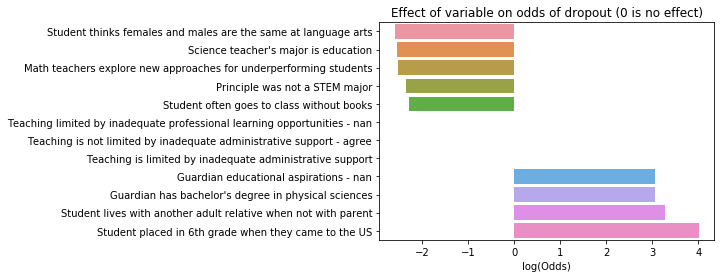

In [55]:
pos_labels = ['Guardian educational aspirations - nan',
              'Guardian has bachelor\'s degree in physical sciences',
              'Student lives with another adult relative when not with parent',
              'Student placed in 6th grade when they came to the US',
              'Student has not stopped attending school for a month or more'
              ]
mid_labels = ['Teaching limited by inadequate professional learning opportunities - nan',
              'Teaching is not limited by inadequate administrative support - agree',
              'Teaching is limited by inadequate administrative support',
             ]
neg_labels = ['Student thinks females and males are the same at language arts',
              'Science teacher\'s major is education',
              'Math teachers explore new approaches for underperforming students',
              'Principle was not a STEM major',
              'Student often goes to class without books'
             ]
    
plot_labels = neg_labels + mid_labels + pos_labels
ax = sns.barplot(y = plot_labels[0:12], x = plot_odds[0:12],order = plot_labels[0:12],orient = 'h')
plt.title('Effect of variable on odds of dropout (0 is no effect)')
plt.xlabel('log(Odds)')
plt.show()

## Conclusions

We can see that there are several important factors that lower the odds of dropping out, including how students perceive male vs female scholastic performance, math teachers' approaches, and whether or not students come without their books.

There are also several factors that increase the odds of dropping out of high school, such as a student being placed in 6th grade when coming to the US and living with another adult relative when they are not with a parent.

However, one variable has been left off the graph, when we add this variable we can see that if a student has never stopped attending school for more than a month, their odds of dropping out increases tremendously. This doesn't make intuitive sense, as attendance is widely seen as a positive force that prevents dropping out. Developing a model that removes the effect of confounding variables to find explainable relationships would be a worthwhile avenue, but may require new data collection.

In future work with this model, we will try to improve the recall to capture more students in danger of dropping out. This must be balanced with a certain level of precision to prevent diverting resources to students needlessly. For example, delivering an intervention to all students would capture every potential dropout, but cost about 10 times more than one that targeted potential dropouts effectively.

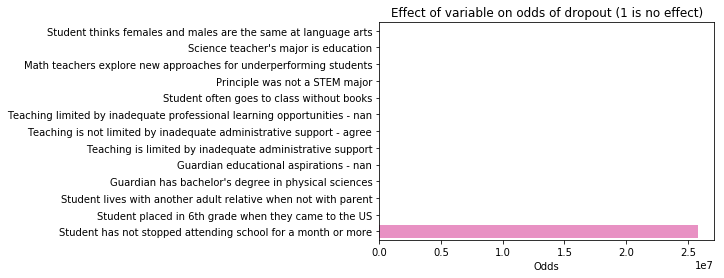

In [54]:
ax = sns.barplot(y = plot_labels, x = np.exp(plot_odds),order = plot_labels,orient = 'h')
plt.title('Effect of variable on odds of dropout (1 is no effect)')
plt.xlabel('Odds')
plt.show()